# Excess mortality in different countries during the covid19 pandemics

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
import matplotlib

from matplotlib.patches import Polygon

In [2]:
from sklearn.linear_model import LinearRegression

def predict(X, maxyear=2019):
    ind = (X[:,0] >= 2015) & (X[:,0] <= maxyear)
    m = np.max(X[ind,1]).astype(int)
    if m == 51: # the first and the last weeks are absent for some countries
        m = 50
    predictors = np.concatenate((X[ind,:1], np.concatenate([np.eye(m)]*(np.sum(ind)/m).astype(int))), axis=1)
    reg = LinearRegression().fit(predictors, X[ind,2])
    predictors = np.eye(m)
    predictors = np.concatenate((np.ones((m,1))*2020, predictors), axis=1)
    pred = reg.predict(predictors)
    
    diff = X[X[:,0]==2020, 2] - pred[X[X[:,0]==2020, 1].astype(int)-1]

    return pred, diff

In [3]:
# Will accumulate data from various sources here

mega = {}

In [4]:
# Human mortality database

df = pd.read_csv('https://www.mortality.org/Public/STMF/Outputs/stmf.csv', header=1)

countries = np.unique(df['CountryCode'])
countries = [c for c in countries if c not in ['RUS','GBRTENW','GBR_NIR','GBR_SCO']]
countries = countries + ['GBR']

countries_dict = {'AUS2':'Australia','AUT':'Austria','BEL':'Belgium','BGR':'Bulgaria',
                  'CAN':'Canada','CHE':'Switzerland','CHL':'Chile','CZE':'Czech Republic',
                  'DEUTNP':'Germany','DNK':'Denmark','ESP':'Spain','EST':'Estonia','FIN':'Finland',
                  'FRATNP':'France','GBR':'United Kingdom','GRC':'Greece','HRV':'Croatia','HUN':'Hungary',
                  'ISL':'Iceland','ISR':'Israel','ITA':'Italy','KOR':'South Korea','LTU':'Lithuania',
                  'LUX':'Luxembourg','LVA':'Latvia','NLD':'Netherlands','NOR':'Norway',
                  'NZL_NP':'New Zealand','POL':'Poland','PRT':'Portugal','SVK':'Slovakia',
                  'SVN':'Slovenia','SWE':'Sweden','TWN':'Taiwan','USA':'United States'}

HMD = list(countries_dict.values())

for i,country in enumerate(countries):
    print(countries_dict[country])
    
    if country!='GBR':
        X = df[(df['CountryCode']==country)&(df['Sex']=='b')&(df['Year']>=2015)][['Year','Week','DTotal']].values
    else:
        # Add up numbers for UK
        X1 = df[(df['CountryCode']=='GBRTENW')&(df['Sex']=='b')&(df['Year']>=2015)][['Year','Week','DTotal']].values
        X2 = df[(df['CountryCode']=='GBR_NIR')&(df['Sex']=='b')&(df['Year']>=2015)][['Year','Week','DTotal']].values
        X3 = df[(df['CountryCode']=='GBR_SCO')&(df['Sex']=='b')&(df['Year']>=2015)][['Year','Week','DTotal']].values
        m = min(X1.shape[0],X2.shape[0],X3.shape[0])
        X1[:m,2] = X1[:m,2]+X2[:m,2]+X3[:m,2]
        X = X1
        
    # kick out last two weeks
    X = X[:-2,:]
    
    # one of the countries did not have data for early 2015
    if X[0,1]>1:
        X = X[X[:,0]>=2016,:]
        
    pred, diff = predict(X)
    mega[countries_dict[country]] = [X,pred,diff]

Australia
Austria
Belgium
Bulgaria
Canada
Switzerland
Chile
Czech Republic
Germany
Denmark
Spain
Estonia
Finland
France
Greece
Croatia
Hungary
Iceland
Israel
Italy
South Korea
Lithuania
Luxembourg
Latvia
Netherlands
Norway
New Zealand
Poland
Portugal
Slovakia
Slovenia
Sweden
Taiwan
United States
United Kingdom


In [5]:
# Financial Times

df = pd.read_csv('https://github.com/Financial-Times/coronavirus-excess-mortality-data/blob/master/data/ft_excess_deaths.csv?raw=true')

countries = np.unique(df['country'])
countries = [c for c in countries if c not in ['Indonesia','Turkey','US','S Korea','UK'] + HMD]

for i,country in enumerate(countries):
    print(country)
    
    X = df[(df['country']==country)&(df['region']==country)&(df['year']>=2015)][['year','month','week','deaths']].values
    
    # Brazil is broken, does not have week numbers
    if country=='Brazil':
        X[X[:,0]==2019,2] = np.arange(np.sum(X[:,0]==2019))+1
        X[X[:,0]==2020,2] = np.arange(np.sum(X[:,0]==2020))+1
    
    if ~np.isnan(X[0,2]):
        X = X[:,[0,2,3]]
        X = X[X[:,1]<=52, :]
    else:
        X = X[:,[0,1,3]]
        
    # Manually adding November for Russia
    if country=='Russia' and X[-1][1]==10:
        X = np.concatenate((X,[[2020,11,219872]]))

    # Mexico does not have full 2019 data, so projecting based on 2015-18
    if country=='Mexico':
        pred, diff = predict(X,2018)
    else:
        pred, diff = predict(X)
            
    mega[country] = [X,pred,diff]

Brazil
Ecuador
Mexico
Peru
Russia
South Africa


In [6]:
# New York Times

df = pd.read_csv('https://github.com/nytimes/covid-19-data/blob/master/excess-deaths/deaths.csv?raw=true')

countries = np.unique(df['country'])
countries = [c for c in countries if c not in ['India', 'Indonesia', 'Japan', 'Turkey',
                                               'Ireland', 'Thailand', 'Mexico'] + HMD]

for i,country in enumerate(countries):    
    X = df[(df['country']==country)][['year','month','week','deaths']].values.astype(float)
    if ~np.isnan(X[0,2]):
        X = X[:,[0,2,3]]
    else:
        X = X[:,[0,1,3]]
        
    # Manual update based on the graphic in NYT
    if country=='Bolivia' and X[-1][1]==8:
        X = np.concatenate((X, [[2020,9,7500]]))
             
    if country in mega.keys():
        if X.shape[0] > mega[country][0].shape[0]:
             print(country + ' -- updating')
        else:
             continue
    else:
        print(country)

    pred, diff = predict(X)
    mega[country] = [X,pred,diff]

Bolivia
Colombia


In [7]:
# The Economist

# TO-DO

In [8]:
# Ukraine

country = 'Ukraine'
print(country)

df = pd.read_csv('https://navizv.github.io/covid/sm-06.csv', sep=';')

data = df[df[df.columns[1]]=='Украина'].values[0,2:]
data = data.astype(float)
data = data[~np.isnan(data)]

X = np.zeros(((2020-2006+1)*12, 3)) * np.nan
X[:,0] = np.concatenate([[i]*12 for i in range(2006,2021)])
X[:,1] = np.array(list(np.arange(12)+1) * (2020-2006+1))
X[:data.size,2] = data
X = X[:data.size]
X = X[X[:,0]>=2015]

pred, diff = predict(X)
mega[country] = [X,pred,diff]

Ukraine


In [9]:
# Iran

country = 'Iran'
print(country)

# https://www.sabteahval.ir/avej/Page.aspx?mId=49826&ID=2182&Page=Magazines/SquareshowMagazine

# "Winter" (last entry per Solar Hirji year) starts on Dec 22, so we'll count it as next calendar year

data = [104609,                        #87889, 112465, 131882, 104609  # 1393 (2014)
        91198, 90009, 90451, 95026,    # 1394 (2015)
        90558, 88026, 95737, 94831,    # 1395 (2016) 
        93067, 88002, 94214, 101030,   # 1396 (2017)
        90214, 91737, 93863, 101210,   # 1397 (2018)
        91742, 94441, 103422, 105787,  # 1398 (2019)
        110384, 131294,                # 1399 (2020)
       ]

X = np.zeros(((2020-2015+1)*4, 3)) * np.nan
X[:,0] = np.concatenate([[i]*4 for i in range(2015,2021)])
X[:,1] = np.array(list(np.arange(4)+1) * (2020-2015+1))
X[:len(data),2] = data
X = X[:len(data)]

pred, diff = predict(X)
mega[country] = [X,pred,diff]

Iran


In [10]:
# Population

df = pd.read_csv('https://github.com/datasets/population/blob/master/data/population.csv?raw=true')

mm = {'South Korea':'Korea, Rep.',
      'Slovakia':'Slovak Republic',
      'Russia':'Russian Federation',
      'Iran':'Iran, Islamic Rep.'}

pops = np.zeros(len(mega.keys()))
for i,m in enumerate(mega.keys()):
    # Russia's population should include Crimea because mortality figures do 
    if m=='Russia':
        pops[i] = 146751300 # from Wikipedia    
    elif m in mm:
        pops[i] = df[df['Country Name']==mm[m]]['Value'].values[-1]
    elif m=='Taiwan':
        pops[i] = 23780000
    else:
        pops[i] = df[df['Country Name']==m]['Value'].values[-1]

In [11]:
# Daily reported numbers during the same time period

import datetime

df_official = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv?raw=true')

mm = {'Czech Republic':'Czechia'}

official = np.zeros(len(mega.keys()))
for i,m in enumerate(mega.keys()):
    last = mega[m][0][-1][1].astype(int)
    if last > 12:
        d = f'2020-W{last:02}'
        r = datetime.datetime.strptime(d + '-0', "%Y-W%W-%w")
        r = str(r)[:10]
    elif last > 4:
        if last+1 < 13:
            r = f'2020-{last+1:02}-01'
        else:
            r = '2021-01-01'
    else:
        # Iran
        # https://twitter.com/Mahan_Ghafari/status/1336338070249951236
        r = '2020-09-21'
    
    if m in mm:
        official[i] = df_official[(df_official['location']==mm[m])
                                  &(df_official['date']==r)]['total_deaths'].values[0]
    else:
        official[i] = df_official[(df_official['location']==m)
                                  &(df_official['date']==r)]['total_deaths'].values[0]

<IPython.core.display.Javascript object>


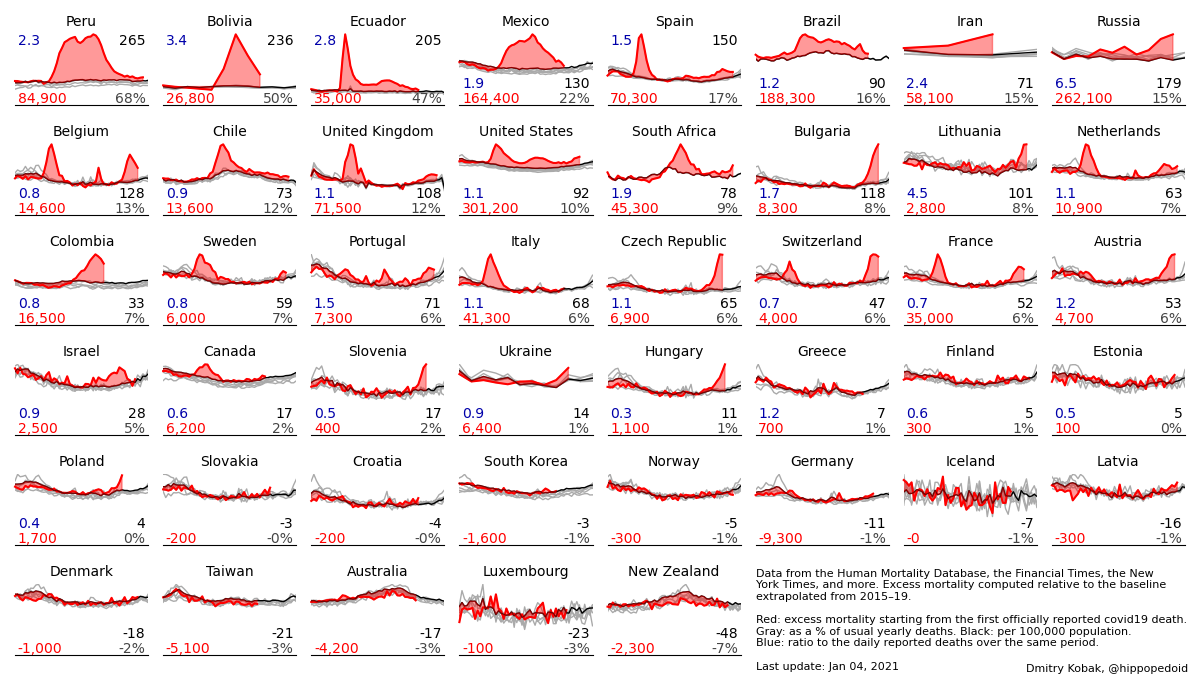

In [12]:
# Make plot

def excess_begin(country):
    X,pred,diff = mega[country] 
    mm = {'Czech Republic':'Czechia'}
    country_lookup = country if country not in mm else mm[country]
    d = df_official[(df_official['location']==country_lookup) 
                & (df_official['total_deaths']>0)]['date'].values[0]
    beg = datetime.date(2020, int(d[5:7]), int(d[8:10])).isocalendar()[1]
    
    if pred.size == 12:
        beg = 3
    elif pred.size == 4:
        beg = 0    

ds = np.zeros(len(mega))
for i,country in enumerate(mega.keys()):
    X,pred,diff = mega[country] 
    d = np.sum(diff[excess_begin(country):])/np.sum(pred)
    ds[i] = d
ind = np.argsort(ds)[::-1]

fig = plt.figure(figsize=(8*1.5,4.5*1.5))

for i,country in enumerate(np.array(list(mega.keys()))[ind]):
    plt.subplot(6,8,i+1)
    
    X,pred,diff = mega[country] 

    for year in np.arange(X[0,0],2020):
        plt.plot(X[X[:,0]==year, 1], X[X[:,0]==year, 2], color='#aaaaaa', lw=1)
    plt.plot(X[X[:,0]==2020, 1], X[X[:,0]==2020, 2], color='r', lw=1.5, clip_on=False)
    plt.plot(np.arange(pred.size)+1, pred, color='k', lw=1)

    beg = excess_begin(country)
    d = np.sum(diff[beg:])
    if np.max(X[:,-1]) < np.mean(pred) * 2.5:
        toplabel = .4
    else:
        toplabel = 1
    plt.text(.02, .03, f'{np.round(d/100)*100:,.0f}', transform=plt.gca().transAxes,
             color='r')
    plt.text(.98, .03, f'{d/np.sum(pred)*100:.0f}%', transform=plt.gca().transAxes, 
             ha='right', color='#444444')
    plt.text(.98, toplabel, f'{d/pops[ind][i]*100000:.0f}', transform=plt.gca().transAxes, 
             ha='right', va='top', color='k')
    if d>0:
        plt.text(.02, toplabel, f'{d/official[ind][i]:.1f}', transform=plt.gca().transAxes, 
                 va='top', color='#0000aa')
        
    beg = excess_begin(country)
    poly1 = np.concatenate((X[X[:,0]==2020, 1][beg:], X[X[:,0]==2020, 1][beg:][::-1]))
    poly2 = np.concatenate((X[X[:,0]==2020, 2][beg:], pred[X[X[:,0]==2020, 1].astype(int)-1][beg:][::-1]))
    poly = np.concatenate((poly1[:,np.newaxis], poly2[:,np.newaxis]), axis=1)
    poly = Polygon(poly, facecolor='r', edgecolor='r', alpha=.4, zorder=5)
    plt.gca().add_patch(poly)
    
    plt.ylim([0,np.max(X[:,-1])])
    plt.xlim([X[X[:,0]==2020, 1][0], pred.size])
    plt.xticks([])
    plt.yticks([])
    plt.title(country, fontsize=10)
    
sns.despine(left=True)
plt.tight_layout()

# fig.text(.99,.01, 'Dmitry Kobak\n@hippopedoid', size=8, ha='right')
fig.text(.99,.005, 'Dmitry Kobak, @hippopedoid', size=8, ha='right')

# fig.text(.55,.001, 'Data from the Human Mortality Database, the Financial Times, the New York Times, and more.\n'
#                 'Excess mortality computed relative to the baseline extrapolated from 2015–19.\n\n'
#                 'Red: excess mortality starting from the first officially reported covid19 death.\n'
#                 'Gray: as a % of usual yearly deaths.\n'
#                 'Black: per 100,000 population.\n'
#                 'Blue: ratio to the daily reported deaths over the same period.\n\n'
#                f'Last update: {datetime.date.today():%b %d, %Y}',
#          fontsize=8, va='bottom'
# )

fig.text(.63,.005, 'Data from the Human Mortality Database, the Financial Times, the New\n'
                   'York Times, and more. Excess mortality computed relative to the baseline\n'
                   'extrapolated from 2015–19.\n\n'
                   'Red: excess mortality starting from the first officially reported covid19 death.\n'
                   'Gray: as a % of usual yearly deaths. Black: per 100,000 population.\n' 
                   'Blue: ratio to the daily reported deaths over the same period.\n\n'
                   f'Last update: {datetime.date.today():%b %d, %Y}',
         fontsize=8, va='bottom'
)

plt.savefig('img/all-countries.png', dpi=200)